In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tau_cal as tau_cal
from pystorm.hal import HAL

In [2]:
# the whole chip
WIDTH = 64 # array width
HEIGHT = 64 # array height

TILE_XY = 4 # height and width of each tile
TILES_X = WIDTH // TILE_XY # number of tiles in x-direction
TILES_Y = HEIGHT // TILE_XY # number of tiles in y-direction

N = WIDTH * HEIGHT

CORE_ID = 0

###########################################
# calibration parameters

FMAX = 1000 # Hz

FMIN_KEEP = 5 # neurons f(0) > FMIN_KEEP have bifurcated (have to account for clobbering)

# |(f(.5 * FMAX) - f(0)) / (f(FMAX) - f(0)) - .5| < FMAX_TOL have not saturated 
# (have to account for noise)
FMAX_TOL_KEEP = .05

TBASELINE = 2 # how long to measure f(0), f(.95 * max), and f(FMAX)  for each neuron

THOLD0 = .5 # how long to hold 0 value before step
THOLD1 = 1 # how long to hold 1 value after step (waiting for synapse to charge up)

# should be enough to make almost everyone bifurcate
DAC_BIAS_SCALE = 1 # avoid > 10
BIAS_TWIDDLE = 1

###########################################

def collapse_multitrial(As):
    A = np.zeros_like(As[0])
    for A_single in As:
        A += A_single
    return A

def get_syn_responses(A, linear):
    S_yx = np.zeros((TILES_Y, TILES_X, A.shape[1]))
    A_yx = A.reshape((TILES_Y * TILE_XY, TILES_X * TILE_XY, A.shape[1]))
    A_yx_lin = (A_yx.transpose(2, 0, 1) * linear).transpose(1, 2, 0)
    for ty in range(TILES_Y):
        for tx in range(TILES_X):
            for sample_idx in range(A_yx_lin.shape[2]):
                S_yx[ty, tx, sample_idx] = np.sum(A_yx_lin[ty*TILE_XY : (ty+1)*TILE_XY, tx*TILE_XY : (tx+1)*TILE_XY, sample_idx])
    return S_yx

def combine_quadrant_responses(S_yxs, syn_yxs):
    assert(S_yxs[0].shape[0] == TILES_Y)
    assert(S_yxs[0].shape[1] == TILES_X)
    assert(len(syn_yxs) == len(S_yxs))
    assert(len(syn_yxs) == 4)
    Sall_yx = np.zeros((TILES_Y * 2, TILES_X * 2, S_yxs[0].shape[2]))
    for syn_yx, S_yx in zip(syn_yxs, S_yxs):
        syn_y, syn_x = syn_yx
        Sall_yx[syn_y::2, syn_x::2, :] = S_yx
    return Sall_yx

def respfunc(t, tau):
    return 1 - np.exp(-t / tau)

def fit_taus(S_yxs, thold0, thold1, plot=False, plot_fname_pre=None, pyx=8):

    from scipy.optimize import curve_fit

    taus = np.zeros((S_yxs.shape[0], S_yxs.shape[1]))
    Z_mins = np.zeros_like(taus)
    Z_maxs = np.zeros_like(taus)

    idx_start = int(np.round(thold0 / (thold0 + thold1) * S_yxs.shape[2]))
    len_Z_on = S_yxs.shape[2] - idx_start
    
    Z_ons = np.zeros((S_yxs.shape[0], S_yxs.shape[1], len_Z_on))
    curves = np.zeros_like(Z_ons)
    
    for ty in range(S_yxs.shape[0]):
        for tx in range(S_yxs.shape[1]):
            Z = S_yxs[ty,tx,:]
            
            # window and renormalize Z so it looks like a standard
            # saturating exponential going 0 -> 1

            # window
            idx_start = int(np.round(thold0 / (thold0 + thold1) * len(Z)))
            Z_off = Z[:idx_start]
            Z_on = Z[idx_start:]
    
            t = np.linspace(0, thold1, len(Z_on))

            # shift and scale
            Z_min = np.mean(Z_off)
            Z_scaled = Z_on - Z_min
            # assume signal is settled in second half of Z_on
            Z_max = np.mean(Z_scaled[Z_scaled.shape[0] // 2:]) 
            Z_scaled = Z_scaled / Z_max
            Z_mins[ty, tx] = Z_min
            Z_maxs[ty, tx] = Z_max
            
            mean_off = np.mean(Z_off)
            Z_on_settled = Z_on[Z_on.shape[0] // 2:]
            mean_on = np.mean(Z_on_settled)

            # if the synapse's (linear) neurons actually responded
            if np.abs(mean_on - mean_off) > .05 * mean_off: 

                popt, pcov = curve_fit(respfunc, t, Z_scaled)
                taus[ty, tx] = popt[0]
                
                curves[ty, tx, :] = Z_max * respfunc(t, taus[ty, tx]) + Z_min
                Z_ons[ty, tx] = Z_on
                
            # if they didn't don't try to estimate tau
            else:
                taus[ty, tx] = np.nan
            
    if plot:
        # histogram of taus
        plt.figure()
        taus_hist = taus[~np.isnan(taus)]
        plt.hist(taus_hist.flatten(), bins=20)
        plt.title('tau distribution\nmean = ' + str(np.mean(taus_hist)) + ' std = ' + str(np.std(taus_hist)))
        plt.savefig(plot_fname_pre + '_tau_hist.png')

        # imshow of tau locations
        plt.figure()
        plt.imshow(taus)
        plt.savefig(plot_fname_pre + '_tau_locations.png')
        plt.colorbar()

        # step response curve fits
        plot_yx_data([Z_ons[:pyx, :pyx, :], curves[:pyx, :pyx, :]], mask=~np.isnan(taus), t=t)
        plt.savefig(plot_fname_pre + '_curve_fits.png')

    return taus

In [3]:
hal = HAL()

/home/scottreid/Measurements/Braindrop_Utilities/tau_cal.py:205: RuntimeWarning: divide by zero encountered in true_divide
  fdiff_frac = (fhigh - f0) / (fmax - f0) # just eat the arithmetic errors for fmax=f0=0
/home/scottreid/Measurements/Braindrop_Utilities/tau_cal.py:205: RuntimeWarning: invalid value encountered in true_divide
  fdiff_frac = (fhigh - f0) / (fmax - f0) # just eat the arithmetic errors for fmax=f0=0
/home/scottreid/Measurements/Braindrop_Utilities/tau_cal.py:208: RuntimeWarning: invalid value encountered in greater
  fdiff_frac[fdiff_frac > .5 + .05] = .5 + .05
/home/scottreid/Measurements/Braindrop_Utilities/tau_cal.py:209: RuntimeWarning: invalid value encountered in less
  fdiff_frac[fdiff_frac < .5 - .05] = .5 - .05
/home/scottreid/Measurements/Braindrop_Utilities/tau_cal.py:215: RuntimeWarning: invalid value encountered in less
  not_sat = abs(fdiff_frac - .5) < FMAX_TOL_KEEP
/home/scottreid/Measurements/Braindrop_Utilities/tau_cal.py:228: RuntimeWarning: divid

frac. fired =  0.7678
frac. fired and not saturated =  0.2695
frac. NOT fired and not saturated =  0.1184
start_s 26.99447
end_s 28.49447
start_s 28.78447
end_s 30.28447
start_s 30.56447
end_s 32.06447
start_s 32.34447
end_s 33.84447
start_s 34.11447
end_s 35.61447
start_s 35.89447
end_s 37.39447
start_s 37.66447
end_s 39.16447
start_s 39.43447
end_s 40.93447
start_s 41.20447
end_s 42.70447
start_s 42.97447
end_s 44.47447
start_s 44.74447
end_s 46.24447
start_s 46.51447
end_s 48.01447
start_s 48.30447
end_s 49.80447
start_s 50.08447
end_s 51.58447
start_s 51.86447
end_s 53.36447
start_s 53.64447
end_s 55.14447
start_s 55.42447
end_s 56.92447
start_s 57.19447
end_s 58.69447
start_s 58.97447
end_s 60.47447
start_s 60.74447
end_s 62.24447
frac. fired =  0.8083
frac. fired and not saturated =  0.3901
frac. NOT fired and not saturated =  0.1035
start_s 73.29447
end_s 74.79447
start_s 75.08447
end_s 76.58447
start_s 76.86447
end_s 78.36447
start_s 78.65447
end_s 80.15447
start_s 80.45447
end

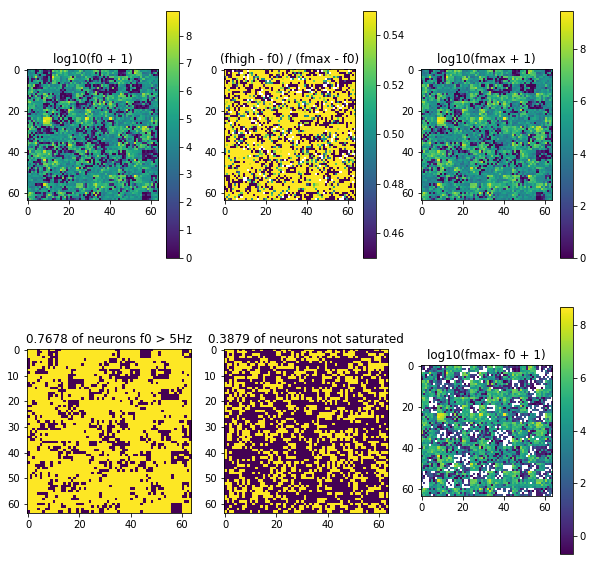

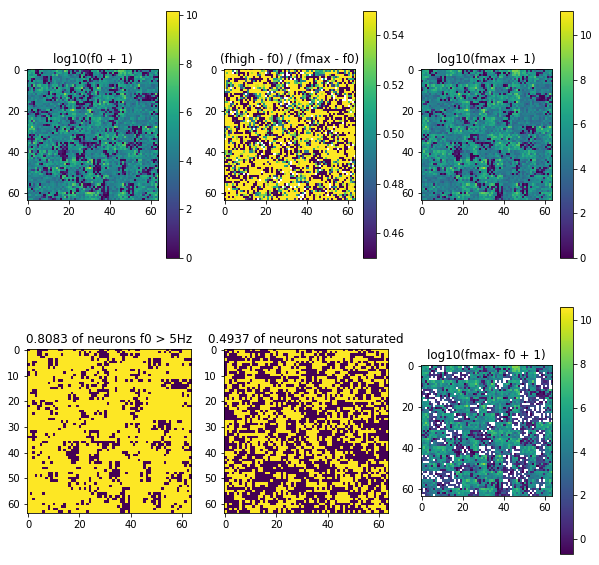

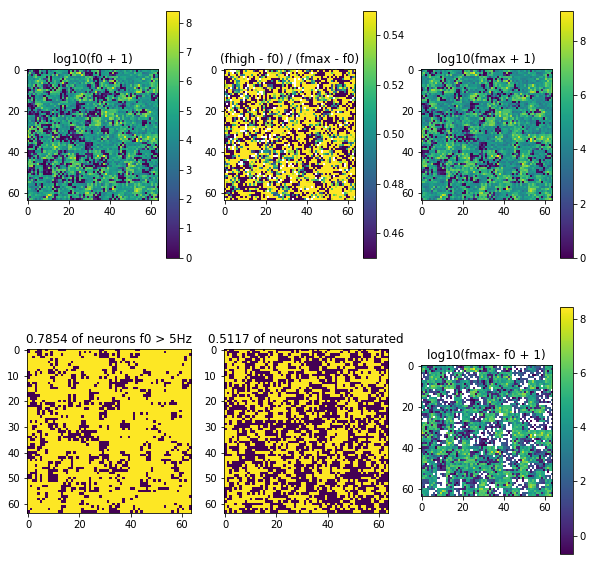

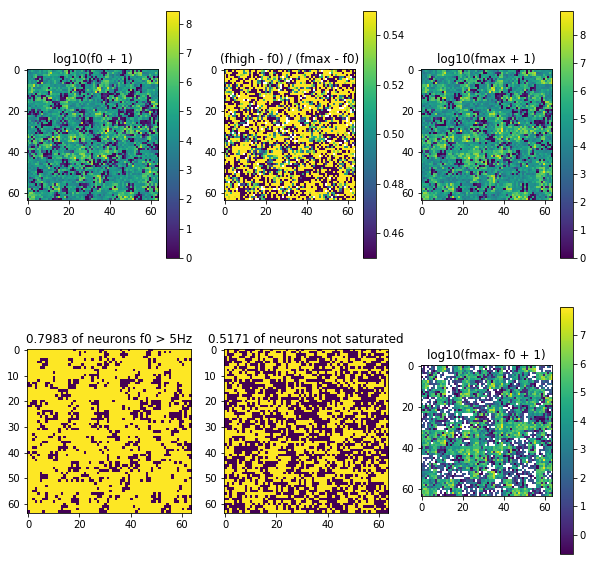

In [4]:
all_binned, all_linear = tau_cal.run_tau_exp(hal, 20, 1)

In [156]:
collapsed_As = [collapse_multitrial(all_binned[k]) for k in all_binned]
syn_yx_list = [k for k in all_binned]
linear_list = [all_linear[k] for k in all_binned]

# combine data from quadrants
S_yxs = [get_syn_responses(A, linear) for A, linear in zip(collapsed_As, linear_list)]
Sall_yx = combine_quadrant_responses(S_yxs, syn_yx_list)

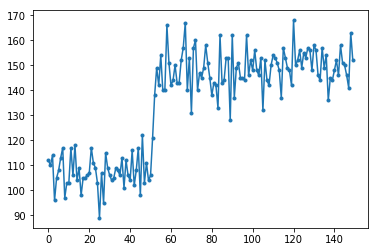

In [169]:
plt.plot(Sall_yx[0,12], '.-')

In [170]:
taus = fit_taus(Sall_yx, THOLD0, THOLD1, plot=False)

/home/scottreid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
/home/scottreid/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


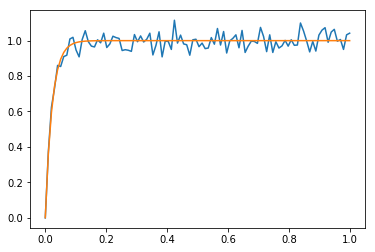

In [189]:
from scipy.optimize import curve_fit

ty = 3
tx = 8

Z = Sall_yx[ty,tx,:]

# window and renormalize Z so it looks like a standard
# saturating exponential going 0 -> 1

# window
idx_start = int(np.round(THOLD0 / (THOLD0 + THOLD1) * len(Z)))
Z_off = Z[:idx_start]
Z_on = Z[idx_start:]

t = np.linspace(0, THOLD1, len(Z_on))

# shift and scale
Z_min = np.mean(Z_off)
Z_scaled = Z_on - Z_min
# assume signal is settled in second half of Z_on
Z_max = np.mean(Z_scaled[Z_scaled.shape[0] // 2:]) 
Z_scaled = Z_scaled / Z_max

mean_off = np.mean(Z_off)
Z_on_settled = Z_on[Z_on.shape[0] // 2:]
mean_on = np.mean(Z_on_settled)

# if the synapse's (linear) neurons actually responded
if np.abs(mean_on - mean_off) > .05 * mean_off: 

    popt, pcov = curve_fit(respfunc, t, Z_scaled)
    tau = popt[0]

#     curves[ty, tx, :] = Z_max * respfunc(t, taus[ty, tx]) + Z_min
#     Z_ons[ty, tx] = Z_on

# if they didn't don't try to estimate tau
else:
    tau = np.nan
    
plt.plot(t, Z_scaled)
plt.plot(t, respfunc(t, tau))

(array([504., 188.,  21.,   7.,   1.,   0.,   0.,   2.,   0.,   1.]),
 array([1.30320250e-02, 2.44657394e+01, 4.89184468e+01, 7.33711542e+01,
        9.78238616e+01, 1.22276569e+02, 1.46729276e+02, 1.71181984e+02,
        1.95634691e+02, 2.20087399e+02, 2.44540106e+02]),
 <a list of 10 Patch objects>)

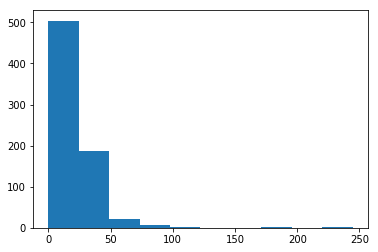

In [196]:
plt.hist(1000*taus[~np.isnan(taus)])